In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [5]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, last_tune_log, tune, Verbosity
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "015"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "nyt-connections"},
)

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
random.seed(42)
random.shuffle(train_tasks)
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(436, 72, 92, 436)

In [8]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.05
wandb.config["kl_coef"] = kl_coef = 0.01

expected_tokens = 4000  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 5e-5
model = models.qwen_32b()
wandb.config["model"] = model_name = model.base_model
num_iterations = 10
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 64
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 0 # See if we can overfit on the first tasks
wandb.config["tasks_per_iter"] = tasks_per_iter = 8
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-32B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --port=8001 --api-key=default
INFO 02-19 16:28:34 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 16:28:35 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 16:28:35 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-32B', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.51it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.44it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:02<00:03,  1.42it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:02,  1.42it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:03<00:02,  1.47it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:04<00:01,  1.46it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.45it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.76it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.56it/s]



INFO 02-19 16:28:59 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=44310) INFO 02-19 16:28:59 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=44308) INFO 02-19 16:29:00 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=44309) INFO 02-19 16:29:00 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=44308) INFO 02-19 16:29:04 worker.py:267] Memory profiling takes 4.13 seconds
(VllmWorkerProcess pid=44308) INFO 02-19 16:29:04 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=44308) INFO 02-19 16:29:04 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 4.13GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.16GiB.
(VllmWorkerProcess pid=44310) INFO 02-19 16:29:04 worker.py:267] Memory profiling takes 4

INFO:     Started server process [43886]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-19 16:30:16 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 16:30:16 metrics.py:455] Avg prompt throughput: 0.9 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 16:30:16 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:34886 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x769ccd3d28e0>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-537' coro=<get_chat_completion() done, defined at /home/gcpuser/sky_workdir/experiments/lib/chat_completions.py:59> exception=APIConnectionError('Connection error.')>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/.venv/lib/python3.12/site-packages/httpx/_transports/default.py", line 101, in map_httpcore_exceptions
    yield
  File "/home/gcpuser/sky_workdir/.venv/lib/python3.12/site-packages/httpx/_transports/default.py", line 394, in handle_async_request
    resp = await self._pool.handle_async_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcpuser/sky_workdir/.venv/lib/python3.12/site-packages/httpcore/_async/connection_pool.py", line 256, in handle_async_request
    raise exc from None
  File "/home/gcpuser/sky_workdir/.venv/lib/python3.12/site-packages/httpcore/_async/connection_pool.py", line 236, in handle_async_request
    response = await c

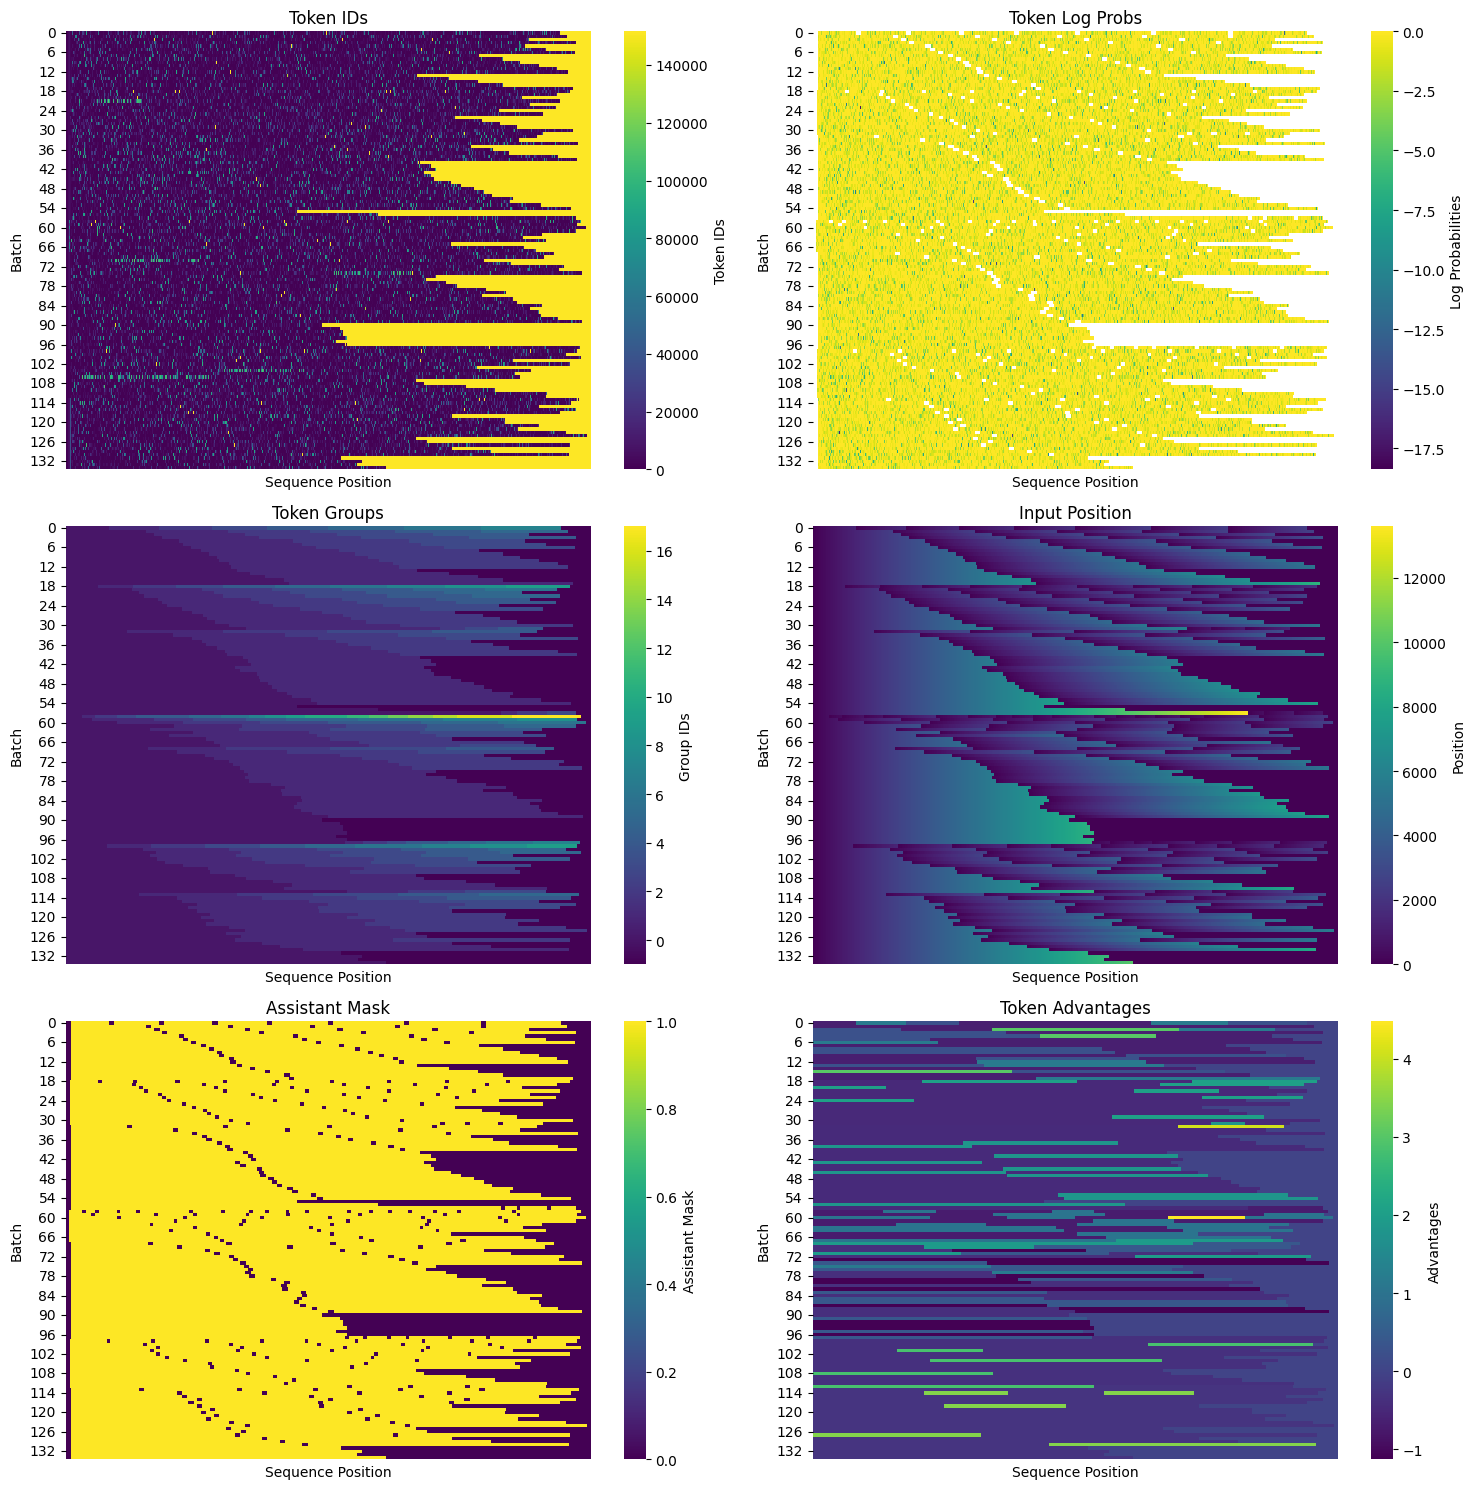

$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/015/config.yaml
Running with torchrun...


W0219 16:41:15.875000 49361 torch/distributed/run.py:793] 
W0219 16:41:15.875000 49361 torch/distributed/run.py:793] *****************************************
W0219 16:41:15.875000 49361 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0219 16:41:15.875000 49361 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer

Writing logs to models/015/logs/log_1739983281.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 58.56 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 9.81 GiB
	GPU peak memory reserved: 10.04 GiB
	GPU peak memory active: 9.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|17|Loss: 0.3414: 100%|██████████| 17/17 [20:19<00:00, 69.91s/it, entropy=0.673, kl_div=0.274, loss=0.341, policy=0.372]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 35.48 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.79 GB sav

Saved iteration #1 model files to ./models/015/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/015/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --served-model-name=./models/015/0001 --port=8000 --api-key=default
INFO 02-19 17:04:34 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 17:04:35 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 17:04:35 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/015/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:05<00:37,  5.42s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:10<00:31,  5.24s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:15<00:25,  5.19s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:20<00:20,  5.16s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:25<00:15,  5.15s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:31<00:10,  5.14s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:36<00:05,  5.19s/it]


(VllmWorkerProcess pid=59664) INFO 02-19 17:05:30 model_runner.py:1115] Loading model weights took 15.4137 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.22s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.81s/it]



(VllmWorkerProcess pid=59662) INFO 02-19 17:05:30 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=59663) INFO 02-19 17:05:30 model_runner.py:1115] Loading model weights took 15.4137 GB
INFO 02-19 17:05:30 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=59663) INFO 02-19 17:05:35 worker.py:267] Memory profiling takes 4.07 seconds
(VllmWorkerProcess pid=59663) INFO 02-19 17:05:35 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=59663) INFO 02-19 17:05:35 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 4.13GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.16GiB.
(VllmWorkerProcess pid=59664) INFO 02-19 17:05:35 worker.py:267] Memory profiling takes 4.07 seconds
(VllmWorkerProcess pid=59664) INFO 02-19 17:05:35 worker.py:267] the current vLLM instance can use

INFO:     Started server process [59243]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 17:06:45 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 17:06:46 metrics.py:455] Avg prompt throughput: 1.1 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 17:06:46 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:43704 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x769ccd3d28e0>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

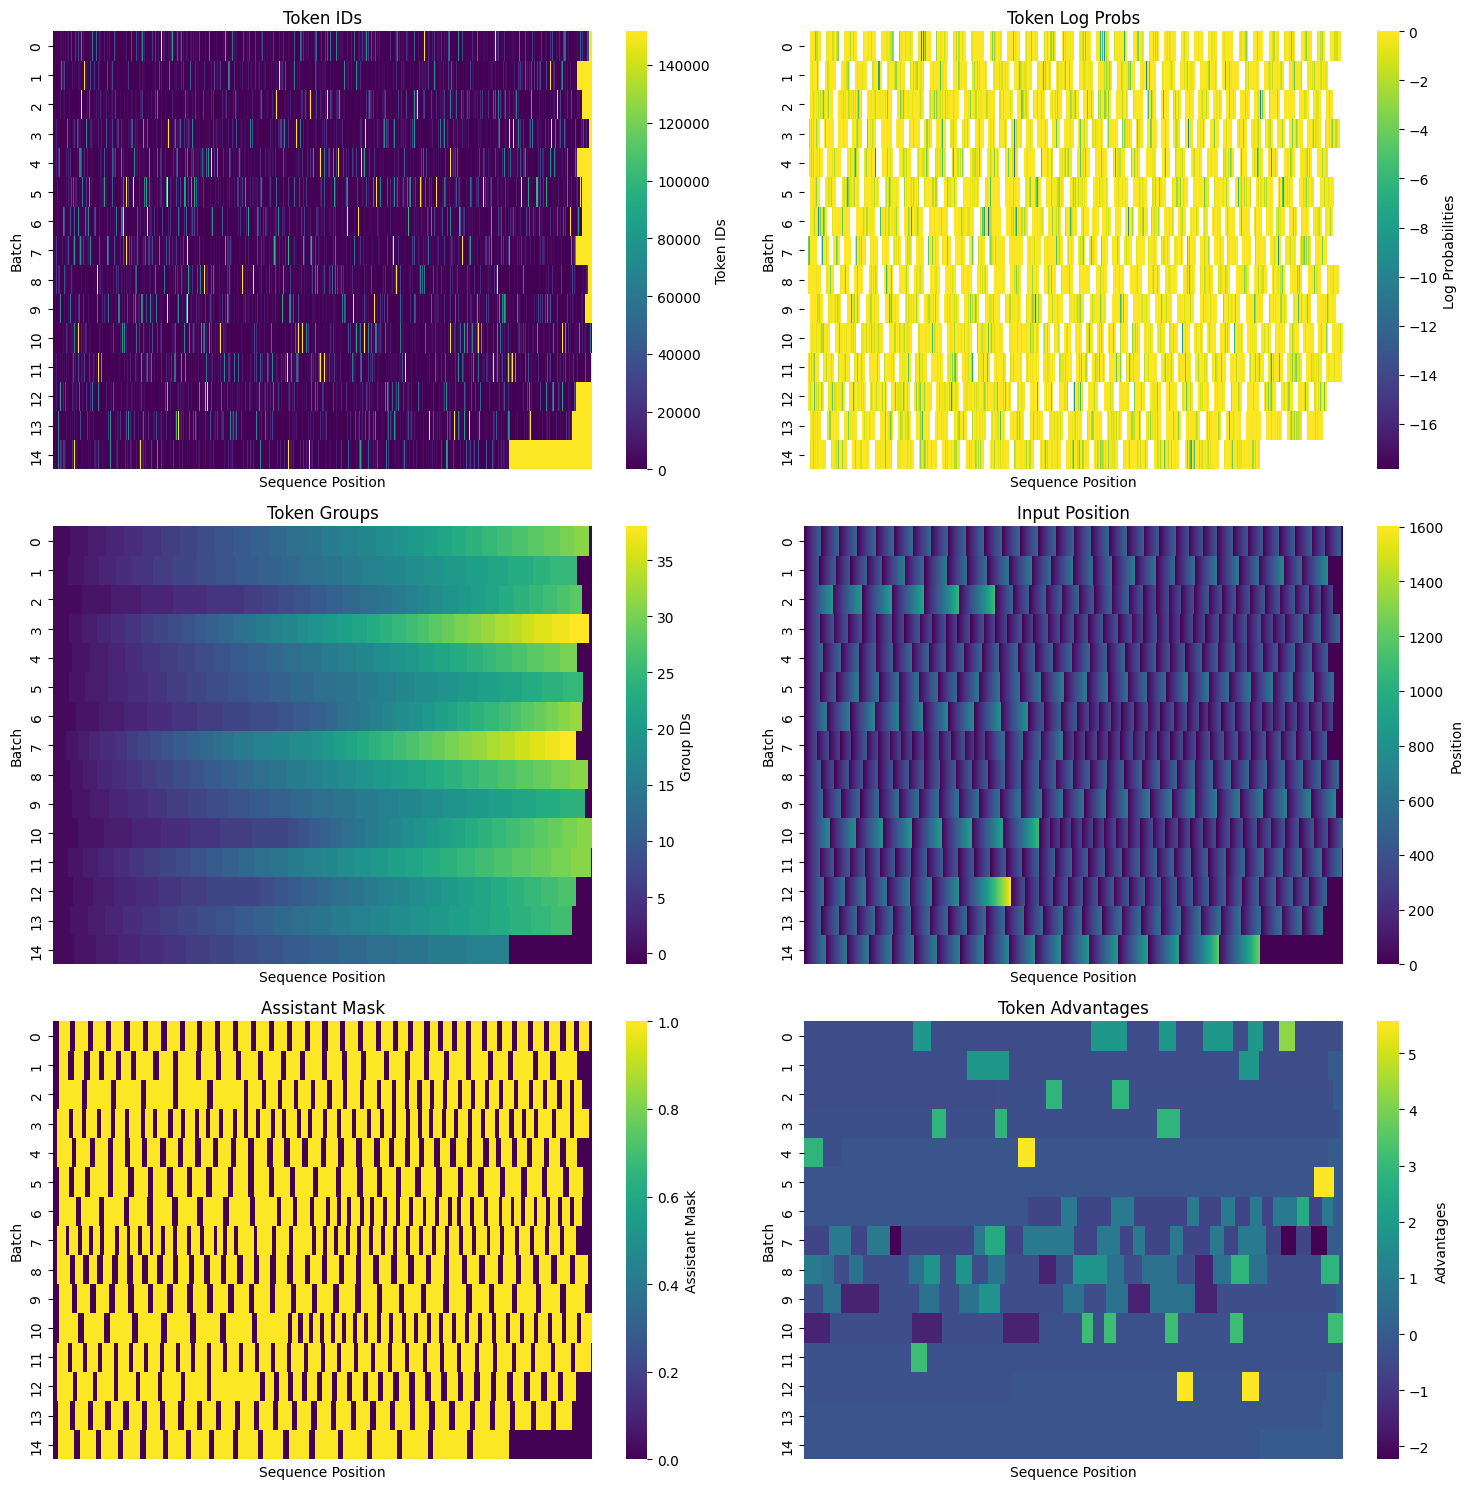

$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/015/config.yaml
Running with torchrun...


W0219 17:08:29.102000 61120 torch/distributed/run.py:793] 
W0219 17:08:29.102000 61120 torch/distributed/run.py:793] *****************************************
W0219 17:08:29.102000 61120 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0219 17:08:29.102000 61120 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/snapshots/3865e12a1eb7

Writing logs to models/015/logs/log_1739984914.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 58.97 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 9.81 GiB
	GPU peak memory reserved: 10.04 GiB
	GPU peak memory active: 9.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|2|Loss: 0.0463: 100%|██████████| 2/2 [02:50<00:00, 82.75s/it, entropy=0.716, kl_div=0.411, loss=0.0463, policy=0.0779]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 35.15 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.79 GB saved t

Saved iteration #1 model files to ./models/015/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/015/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --served-model-name=./models/015/0001 --port=8000 --api-key=default
INFO 02-19 17:14:18 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 17:14:19 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 17:14:19 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/015/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:05<00:37,  5.40s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:10<00:31,  5.26s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:15<00:26,  5.21s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:20<00:20,  5.16s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:25<00:15,  5.14s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:31<00:10,  5.13s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:36<00:05,  5.10s/it]


(VllmWorkerProcess pid=64911) INFO 02-19 17:15:14 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=64909) INFO 02-19 17:15:15 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=64910) INFO 02-19 17:15:15 model_runner.py:1115] Loading model weights took 15.4137 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.16s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.77s/it]



INFO 02-19 17:15:15 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=64911) INFO 02-19 17:15:19 worker.py:267] Memory profiling takes 3.87 seconds
(VllmWorkerProcess pid=64911) INFO 02-19 17:15:19 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=64911) INFO 02-19 17:15:19 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 3.66GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.63GiB.
(VllmWorkerProcess pid=64909) INFO 02-19 17:15:19 worker.py:267] Memory profiling takes 3.87 seconds
(VllmWorkerProcess pid=64909) INFO 02-19 17:15:19 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=64909) INFO 02-19 17:15:19 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 4.13GiB; PyTorch activation pea

INFO:     Started server process [64490]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 17:16:26 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45434 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x769ccd3d28e0>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

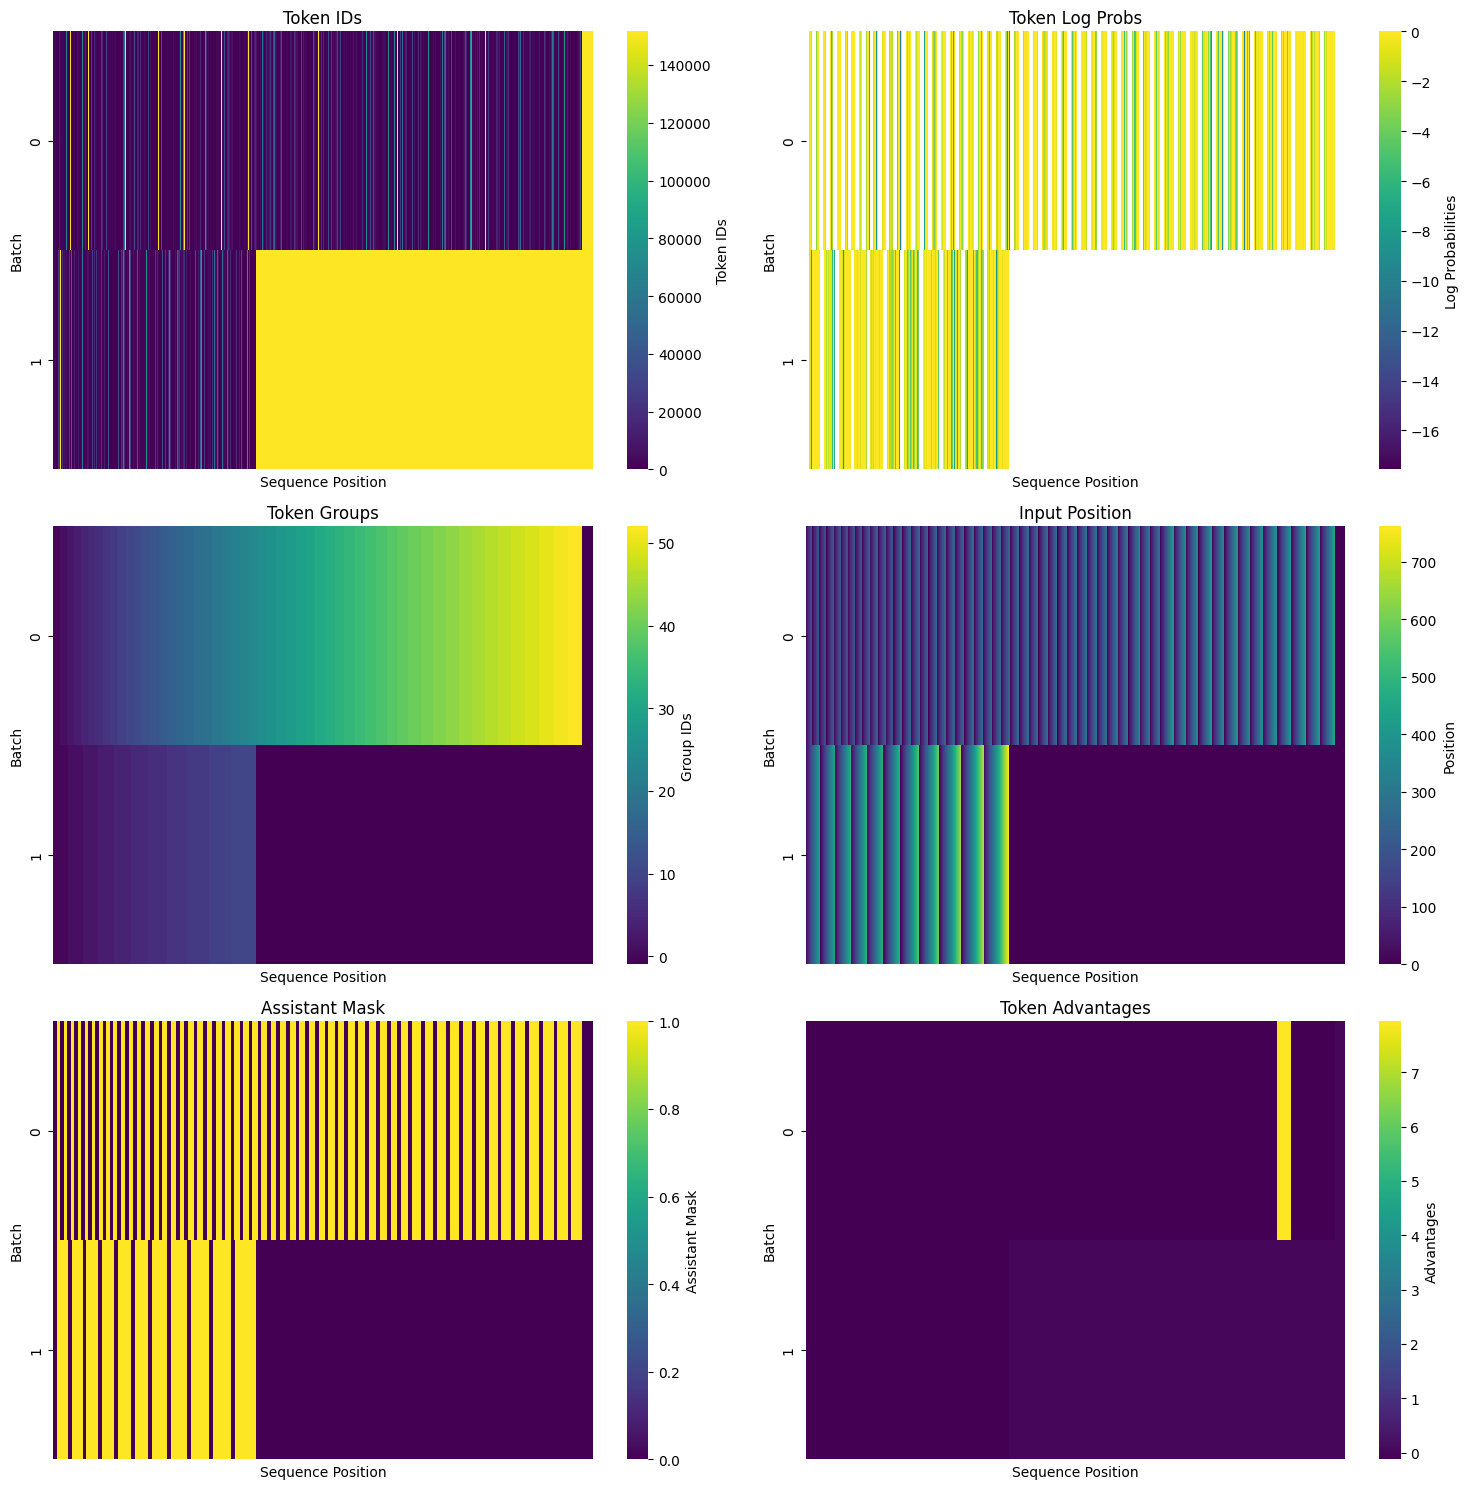

$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/015/config.yaml
Running with torchrun...


W0219 17:19:24.898000 66742 torch/distributed/run.py:793] 
W0219 17:19:24.898000 66742 torch/distributed/run.py:793] *****************************************
W0219 17:19:24.898000 66742 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0219 17:19:24.898000 66742 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/snapshots/3865e12a1eb7

Writing logs to models/015/logs/log_1739985570.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 58.66 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 9.81 GiB
	GPU peak memory reserved: 10.04 GiB
	GPU peak memory active: 9.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
0it [00:00, ?it/s]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 35.16 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.79 GB saved to models/015/hf_model_0001_0.pt
INFO:torchtune.utils._logging:Model checkpoint of size 8.78 GB saved t

Saved iteration #1 model files to ./models/015/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/015/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --served-model-name=./models/015/0001 --port=8000 --api-key=default
INFO 02-19 17:22:04 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 17:22:05 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 17:22:05 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/015/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:05<00:37,  5.40s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:10<00:31,  5.28s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:15<00:25,  5.18s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:20<00:20,  5.14s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:25<00:15,  5.13s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:30<00:10,  5.11s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:36<00:05,  5.11s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.18s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.78s/it]



(VllmWorkerProcess pid=69474) INFO 02-19 17:23:00 model_runner.py:1115] Loading model weights took 15.4137 GB
INFO 02-19 17:23:01 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=69475) INFO 02-19 17:23:01 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=69473) INFO 02-19 17:23:01 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=69473) INFO 02-19 17:23:05 worker.py:267] Memory profiling takes 3.81 seconds
(VllmWorkerProcess pid=69473) INFO 02-19 17:23:05 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=69473) INFO 02-19 17:23:05 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 4.13GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.16GiB.
(VllmWorkerProcess pid=69474) INFO 02-19 17:23:05 worker.py:267] Memory profiling takes 3

INFO:     Started server process [69069]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 17:24:17 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 17:24:18 metrics.py:455] Avg prompt throughput: 0.8 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 17:24:18 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:57054 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x769ccd3d28e0>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

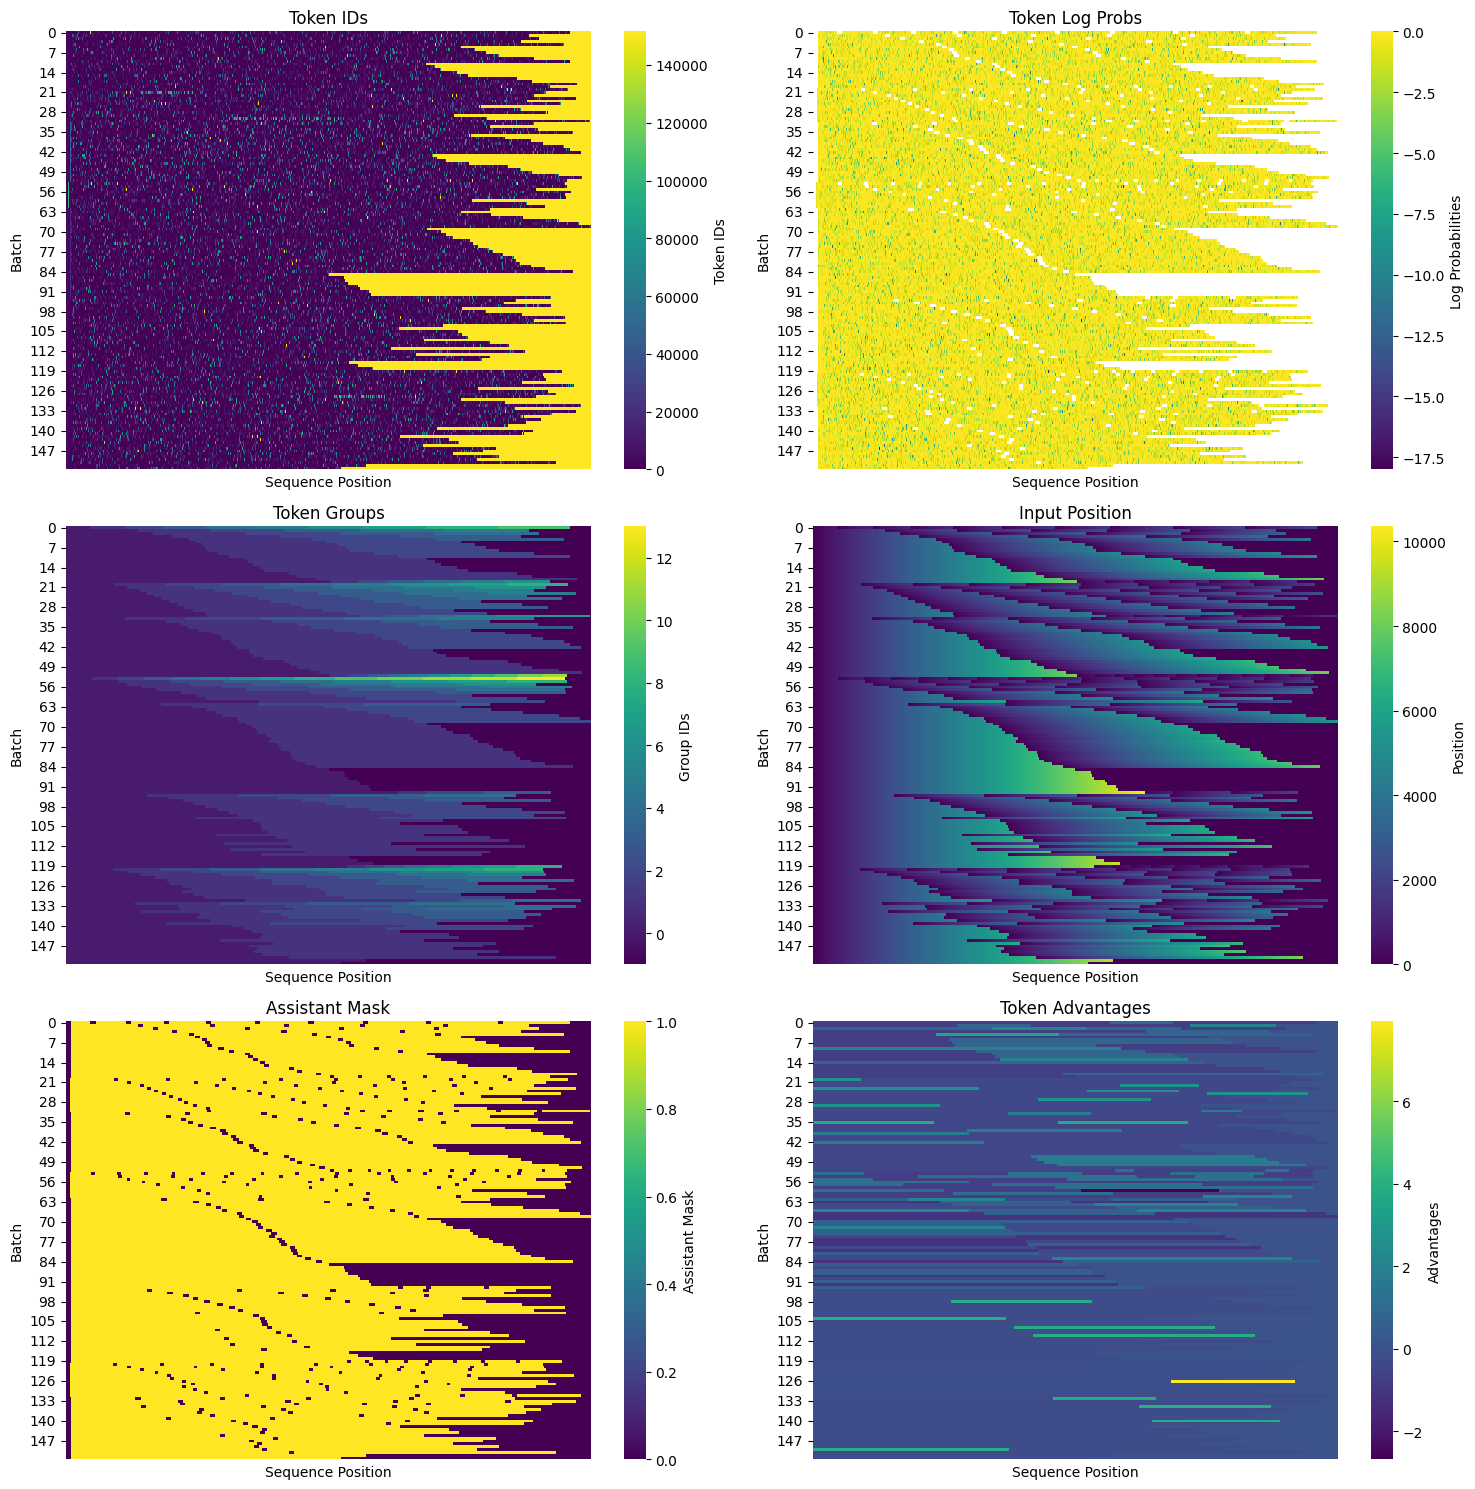

$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/015/config.yaml
Running with torchrun...


W0219 17:35:10.512000 74458 torch/distributed/run.py:793] 
W0219 17:35:10.512000 74458 torch/distributed/run.py:793] *****************************************
W0219 17:35:10.512000 74458 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0219 17:35:10.512000 74458 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/

Writing logs to models/015/logs/log_1739986516.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 58.65 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 9.81 GiB
	GPU peak memory reserved: 10.04 GiB
	GPU peak memory active: 9.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|19|Loss: -0.2361: 100%|██████████| 19/19 [22:39<00:00, 69.87s/it, entropy=0.685, kl_div=0.276, loss=-0.236, policy=-0.205]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 34.96 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.79 GB sav

Saved iteration #1 model files to ./models/015/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/015/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --served-model-name=./models/015/0001 --port=8000 --api-key=default
INFO 02-19 18:00:47 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 18:00:48 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 18:00:48 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/015/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:05<00:37,  5.42s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:10<00:31,  5.23s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:15<00:25,  5.15s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:20<00:20,  5.11s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:25<00:15,  5.19s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:31<00:10,  5.20s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:36<00:05,  5.15s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.21s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.80s/it]



INFO 02-19 18:01:44 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=84977) INFO 02-19 18:01:44 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=84978) INFO 02-19 18:01:44 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=84976) INFO 02-19 18:01:44 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=84978) INFO 02-19 18:01:48 worker.py:267] Memory profiling takes 4.03 seconds
(VllmWorkerProcess pid=84978) INFO 02-19 18:01:48 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=84978) INFO 02-19 18:01:48 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 3.66GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.63GiB.
(VllmWorkerProcess pid=84976) INFO 02-19 18:01:48 worker.py:267] Memory profiling takes 4

INFO:     Started server process [84557]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 18:02:55 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55770 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x769ccd3d28e0>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

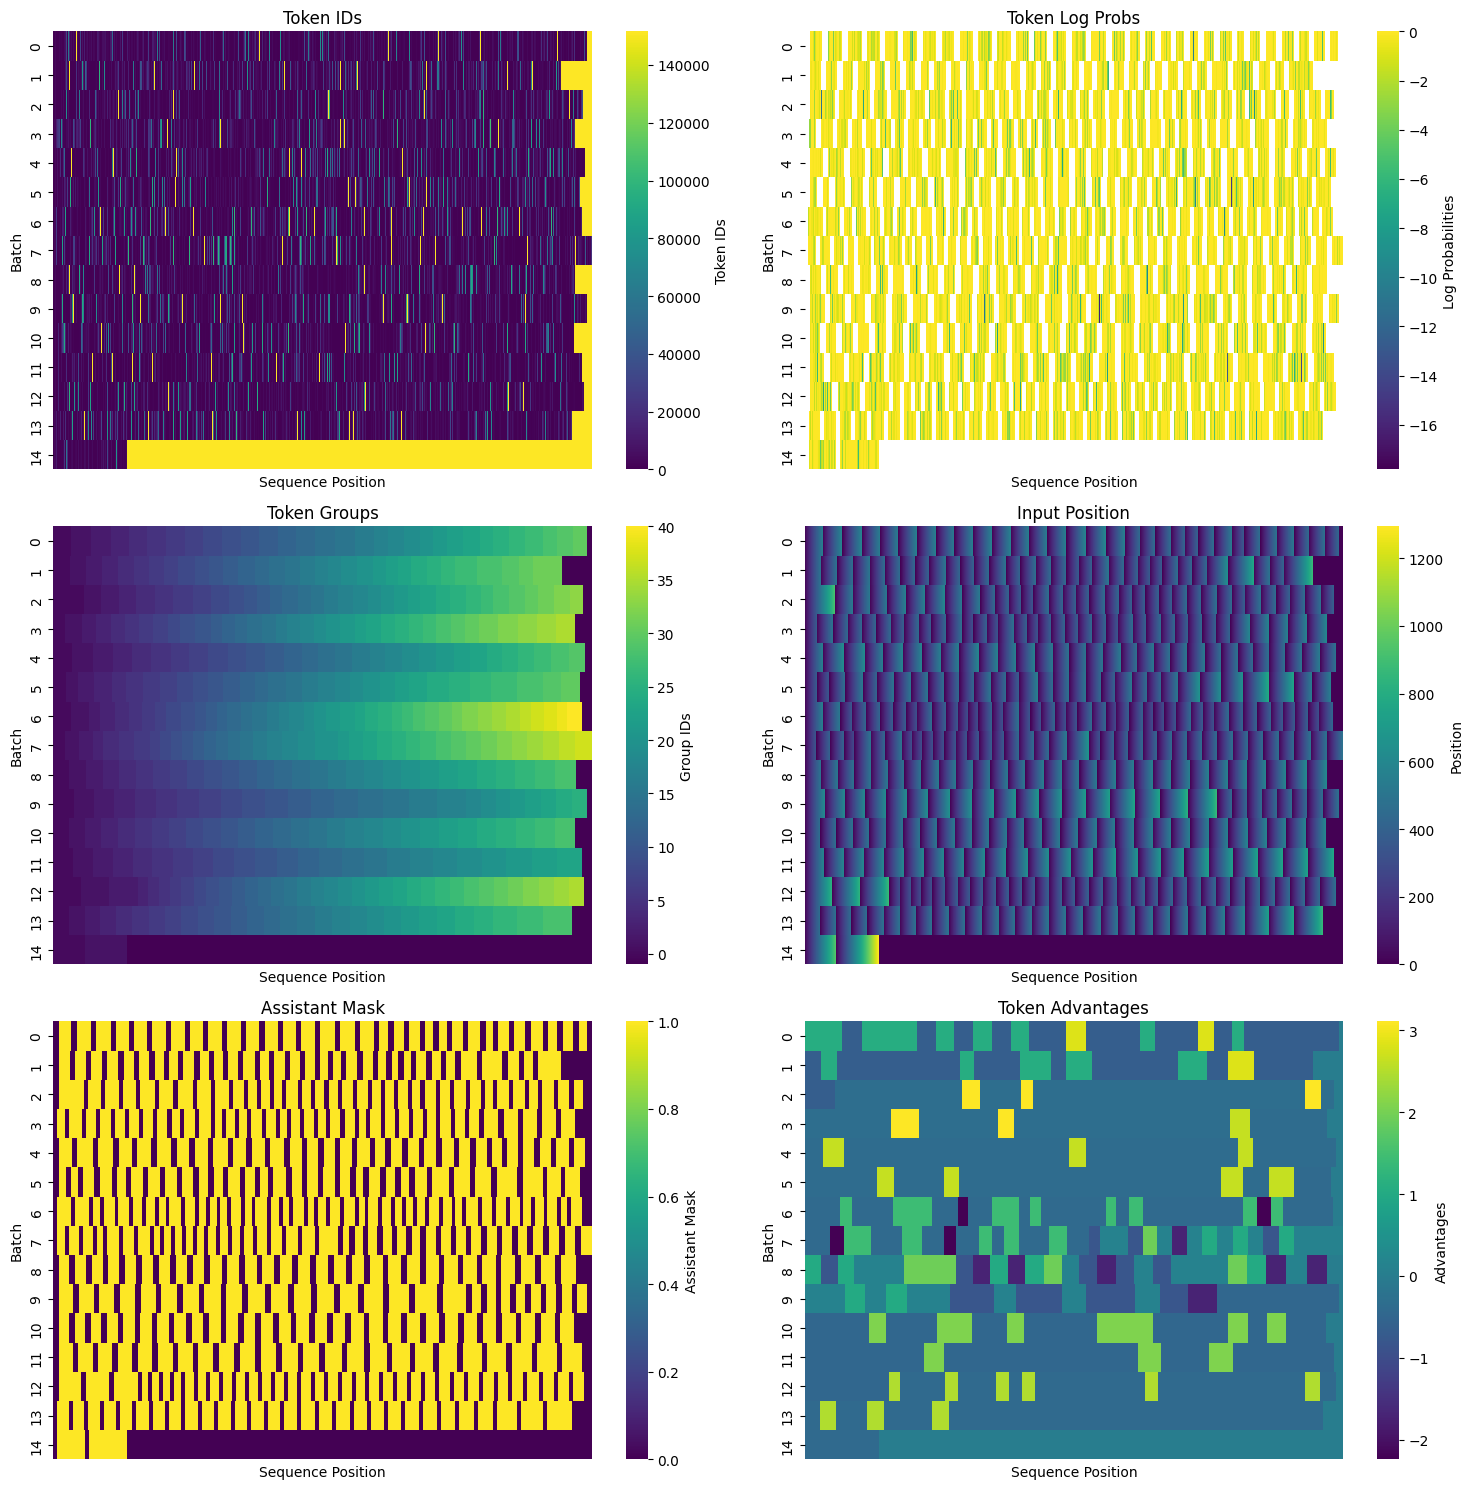

$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/015/config.yaml
Running with torchrun...


W0219 18:04:29.738000 86823 torch/distributed/run.py:793] 
W0219 18:04:29.738000 86823 torch/distributed/run.py:793] *****************************************
W0219 18:04:29.738000 86823 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0219 18:04:29.738000 86823 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/snapshots/3865e12a1eb7

Writing logs to models/015/logs/log_1739988275.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 58.65 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 9.81 GiB
	GPU peak memory reserved: 10.04 GiB
	GPU peak memory active: 9.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|2|Loss: 0.0683: 100%|██████████| 2/2 [02:51<00:00, 83.06s/it, entropy=0.694, kl_div=0.445, loss=0.0683, policy=0.0986]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 35.21 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.79 GB saved t

Saved iteration #1 model files to ./models/015/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/015/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --served-model-name=./models/015/0001 --port=8000 --api-key=default
INFO 02-19 18:10:19 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 18:10:20 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 18:10:20 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/015/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:05<00:37,  5.38s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:10<00:31,  5.21s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:15<00:25,  5.14s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:20<00:20,  5.12s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:25<00:15,  5.09s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:31<00:10,  5.18s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:36<00:05,  5.17s/it]


(VllmWorkerProcess pid=90067) INFO 02-19 18:11:15 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=90068) INFO 02-19 18:11:15 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=90069) INFO 02-19 18:11:15 model_runner.py:1115] Loading model weights took 15.4137 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.22s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:38<00:00,  4.79s/it]



INFO 02-19 18:11:15 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=90069) INFO 02-19 18:11:20 worker.py:267] Memory profiling takes 4.04 seconds
(VllmWorkerProcess pid=90069) INFO 02-19 18:11:20 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=90069) INFO 02-19 18:11:20 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 3.66GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.63GiB.
(VllmWorkerProcess pid=90068) INFO 02-19 18:11:20 worker.py:267] Memory profiling takes 4.16 seconds
(VllmWorkerProcess pid=90068) INFO 02-19 18:11:20 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=90068) INFO 02-19 18:11:20 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 4.13GiB; PyTorch activation pea

INFO:     Started server process [89648]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 18:12:28 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42412 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x769ccd3d28e0>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

/home/gcpuser/sky_workdir/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/gcpuser/sky_workdir/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


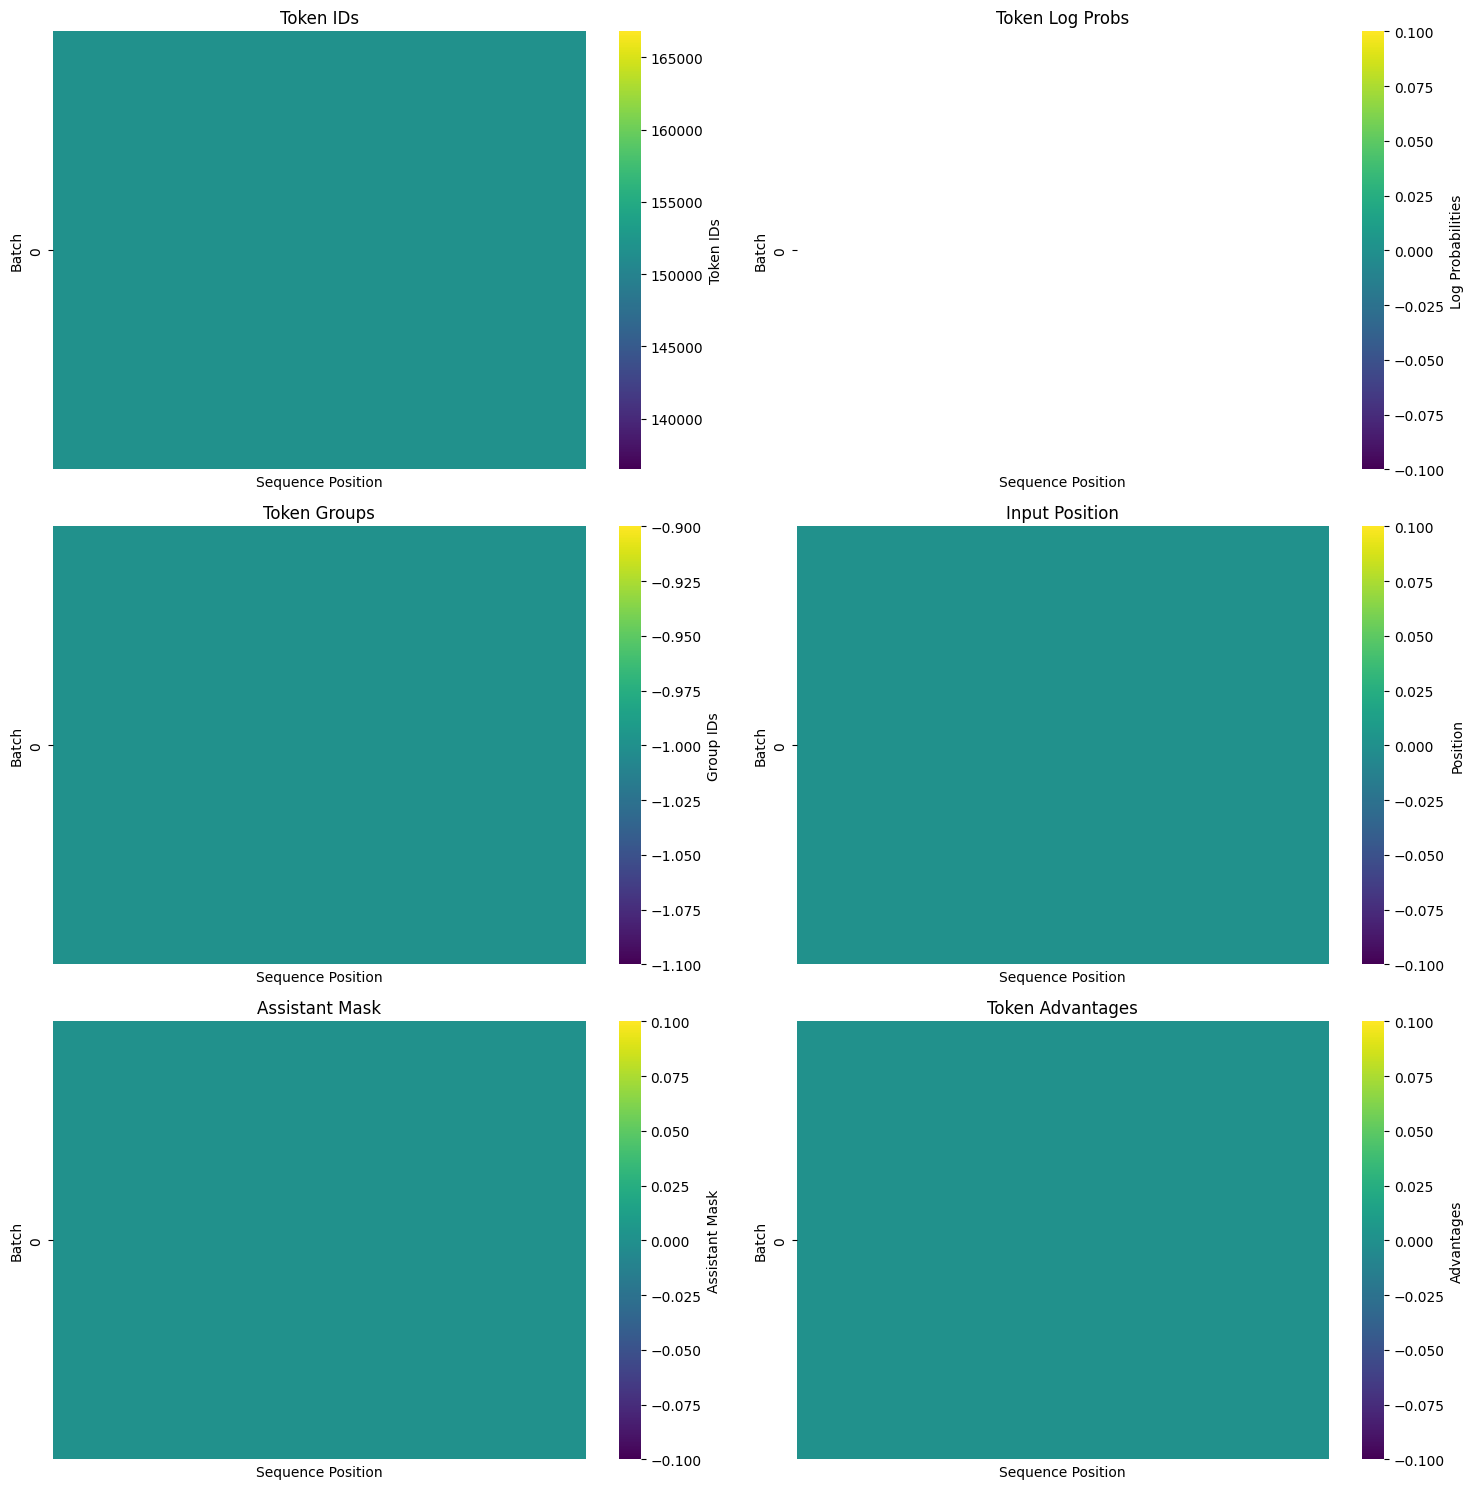

RuntimeError: output with shape [16384] doesn't match the broadcast shape [1, 16384]

In [9]:
for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=512,
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=512,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.2 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": val_stats.completion_tokens / val_stats.usages,
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = round(wandb_data["tokens"])
    vllm.process.terminate()
    kill_vllm_workers()
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, get_iteration(output_dir) - 1])
    except Exception:
        pass
    packed_tensors = packed_tensors_from_tokenized_results(
        [
            result
            for results in train_results
            for result in results
            if result.advantage != 0
        ],
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(model.tune_optimizer, lr=lr)
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()